# Tutorial: Data Analysis with Pre-Processed Motion Data  

Austin MBaye

## **Overview**
In this tutorial, we will walk through the **core data analysis** process for our research using a `.pkl` file. This file contains de-identified motion data from all videos and studies, serving as the foundation for our analysis. 

###  **What’s in the `.pkl` File?**
The `.pkl` file includes key motion tracking data extracted from MediaPipe’s **BlazePose model**, along with additional metadata:

- **`keypoints`** – The **(x, y, visibility)** landmark (or also referred to as keypoint) coordinates for each joint detected in the BlazePose model.
- **`annotations`** – Frame-wise annotations for each video, indicating labeled behaviors.
- **`fps`** – Frames per second (fps) of the video.
- **`frame_count`** – Total number of frames in each video.
- **`duration`** – Video duration in seconds.
- **`name`** – Unique identifier for each entry, structured as (child-date_study).

This `.pkl` file contains all necessary pre-processing data for the analysis, while still allowing room for further modifications or new ideas using the raw MediaPipe keypoint data.

---

## **AQSM-SW1PerS + MediaPipe Algorithm Walkthrough**
The **Automated Quantification of Stereotypical Motor Movements via Sliding Windows and 1-Persistence Scoring (AQSM-SW1PerS)** pipeline follows these key steps:

1.  **Data Colletion** - Optional walkthrough that shows how videos were created and MediaPipe pose inference is run
2.  **Preprocessing** – Cleaning and structuring motion data for analysis.  
3.  **Period Estimation** – Identifying periodic patterns in movement.  
4.  **Optimizing Parameters $d$ and $\tau$** – Finding the best delay embedding parameters for persistence analysis.  
5.  **Computing Sliding Window Embedding** – Transforming motion data into time-delayed embeddings.  
6.  **Computing Persistent Homology & Extracting Features** – Calculating topological persistence and selecting the 10 most persistent points as motion descriptors.



# Data Collection (Optional Walkthrough)

This part of the walkthrough shows how videos were created from publically available data from *Goodwin et. al.* and how to run MediaPipe inference on the videos. As we give all the critical information on the videos and provide all MediaPipe pose landmarks in our `.pkl` file, this section is not critical to any data analysis we do in other sections.


###  **Loading annotations**

The function below extracts annotation information from Goodwin et. al 2014, and are essential for writing the video files. The following are located in **`AQSM_SW1PerS/utils/video_tools.py`**

In [ ]:
from AQSM_SW1PerS.utils.video_tools import *
from AQSM_SW1PerS.utils.paths import get_data_path


In [ ]:
data_folder = 'Study1/URI-001-01-18-08/Annotator1Stereotypy.annotation.xml'  #Replace with the path of any study/session
data_path = get_data_path("data", data_folder)

annotations, good_data = loadAnnotations(data_path)

#Look at annotations
for anno in annotations:
    print(np.vstack(anno))
    print('')

###  **Writing Videos**

We can write videos choosing frames that are within the UNIX start and end times (*good_data*) from the annotations. 

In [ ]:

frames_path = 'Study1/001/URI-001-01-18-08/2008-01-18' #Replace with the path of any study/session

folder_path = get_data_path("autismvideos", frames_path)

output_video = '001-01-18-08' 

frame_annotations = write_video(folder_path, output_video, good_data, annotations)

video_path = f'{output_video}_part_0.avi'


###  **MediaPipe & YOLOv5 Pose Estimation** 

MediaPipe is an open-source framework developed by Google that provides efficient, cross-platform solutions for real-time machine learning pipelines. In this project, we leverage MediaPipe's pose landmarker to capture body movements at a low computational cost compared to other models, such as OpenPose. This task uses a machine learning model on a continuous stream of images. The task outputs 33 landmarks. The following class can be located in `**AQSM_SW1PerS/mediapipe_pose.py**`

The class ``MP_pose`` maybe be initalized with:
 - `time_values` (ndarray (N, 1)): timestamps for each frame of video.
 - `fps` (float): frames per second of video.
 - `model` (path): YOLOv5 model.
 - `create_video` (bool): When set to True, video with skeleton overlayed on person of interest will be saved (Default = True).
 - `min_detection_confidence` (float): The minimum confidence score for the pose detection to be considered successful (Deafult = 0.3).
 - `min_tracking_confidence` (float): The minimum confidence score for the pose tracking to be considered successful (Deafult = 0.3).
 - `model_complexity` (int): Pose landmarker model used. 0 indicates the smallest and fastest model offered while 2 indicates the largest and most robust model offered (Default = 2).

To extract the video information (e.g., time_values, and fps) ``*AQSM_SW1PerS.utils.data_processing**`` provides functions.

In [ ]:
from AQSM_SW1PerS.mediapipe_pose import *
from AQSM_SW1PerS.utils.data_processing import *

windows_os = False #If you are using a windows OS, you may need to turn this to true since we trained YOLO model on UNIX
if windows_os:
    import pathlib
    pathlib.PosixPath = pathlib.WindowsPath
    
model_path = get_data_path("YOLOv5l/yolov5/runs/train/exp/weights", "YOLOv5l_transfer.pt") 
model = torch.hub.load('ultralytics/yolov5', 'custom', path=model_path)

fps, total_frames, duration_seconds, frame_times = get_video_info(video_path)

MPPose = MP_pose(frame_times, fps, model, create_video = False)

MPPose._run_pose_inference(video_path)

# This marks the end of the optional processing of the available data from Goodwin et. al. For the remainder of the tutorial, we use the `*.pkl*` file which contains all of the data we collected above into one easy-to-use dataset.

# Preprocessing

The following functions are located in **`AQSM_SW1PerS/utils/data_processing.py`**.  


In [1]:
from AQSM_SW1PerS.utils.data_processing import *
from AQSM_SW1PerS.utils.paths import get_data_path


In [2]:
pkl_file = get_data_path("dataset.pkl")

data = open_pickle(pkl_file = pkl_file)

index = 0
for entry in data:  # First video entry as example
   
    print(f"Video Name: {entry['name']}, Index: {index}")
    index += 1
    print('')

Video Name: 001-01-18-08_study1, Index: 0

Video Name: 001-01-25-08_study1, Index: 1

Video Name: 001-2010-05-25_study2, Index: 2

Video Name: 001-2010-05-28_study2, Index: 3

Video Name: 001-2010-06-01_study2, Index: 4

Video Name: 002-01-18-08_study1, Index: 5

Video Name: 002-01-24-08_study1, Index: 6

Video Name: 002-2010-06-04_study2, Index: 7

Video Name: 002-2011-06-02_study2, Index: 8

Video Name: 003-01-18-08_study1, Index: 9

Video Name: 003-02-08-08_study1, Index: 10

Video Name: 003-2010-05-07_study2, Index: 11

Video Name: 003-2011-05-23_study2, Index: 12

Video Name: 004-01-17-08_0_study1, Index: 13

Video Name: 004-01-17-08_1_study1, Index: 14

Video Name: 004-01-17-08_2_study1, Index: 15

Video Name: 004-02-07-08_study1, Index: 16

Video Name: 004-2010-04-27_study2, Index: 17

Video Name: 004-2010-05-11_study2, Index: 18

Video Name: 004-2011-03-22_study2, Index: 19

Video Name: 005-01-16-08_study1, Index: 20

Video Name: 005-02-08-08_study1, Index: 21

Video Name: 005-

### Step 1. Window Segmentation:


In [3]:
entry = data[13] 
fps, frame_times, segments, annotated_segments = segment_video(entry, 4)

### Step 2. Landmark Extraction \& Smoothing:

In [4]:
head = extract_landmarks(entry, 0, frame_times, fps)
lshoulder = extract_landmarks(entry, 11, frame_times, fps)
rshoulder = extract_landmarks(entry, 12, frame_times, fps)
rwrist = extract_landmarks(entry, 16, frame_times, fps, do_wrists=True, elbow_index=14, shoulder_index=12)
lwrist = extract_landmarks(entry, 15, frame_times, fps, do_wrists=True, elbow_index=13, shoulder_index=11)

chest = getChest(head, lshoulder, rshoulder)

lshoulder_accel = getAccel(lshoulder,fps)
rshoulder_accel = getAccel(rshoulder,fps)

rwrist_accel = getAccel(rwrist,fps)
lwrist_accel = getAccel(lwrist,fps)

head_accel = getAccel(head,fps)
chest_accel = getAccel(chest,fps)

In [5]:
#Landmark spatial positions splines

h_x, h_y = CubicSpline(frame_times,head[:,0]), CubicSpline(frame_times,head[:,1])

r_x, r_y = CubicSpline(frame_times,rwrist[:,0]), CubicSpline(frame_times,rwrist[:,1])

l_x, l_y = CubicSpline(frame_times,lwrist[:,0]), CubicSpline(frame_times,lwrist[:,1])

rs_x, rs_y = CubicSpline(frame_times,rshoulder[:,0]), CubicSpline(frame_times,rshoulder[:,1])

ls_x, ls_y = CubicSpline(frame_times,lshoulder[:,0]), CubicSpline(frame_times,lshoulder[:,1])

c_x, c_y = CubicSpline(frame_times,chest[:,0]), CubicSpline(frame_times,chest[:,1])

#Acceleration representation of landmark movement splines

h_x_a, h_y_a = CubicSpline(frame_times,head_accel[:,0]), CubicSpline(frame_times,head_accel[:,1])

r_x_a, r_y_a = CubicSpline(frame_times,rwrist_accel[:,0]), CubicSpline(frame_times,rwrist_accel[:,1])

l_x_a, l_y_a = CubicSpline(frame_times,lwrist_accel[:,0]), CubicSpline(frame_times,lwrist_accel[:,1])

rs_x_a, rs_y_a = CubicSpline(frame_times,rshoulder_accel[:,0]), CubicSpline(frame_times,rshoulder_accel[:,1])

ls_x_a, ls_y_a = CubicSpline(frame_times,lshoulder_accel[:,0]), CubicSpline(frame_times,lshoulder_accel[:,1])

c_x_a, c_y_a = CubicSpline(frame_times,chest_accel[:,0]), CubicSpline(frame_times,chest_accel[:,1])


### Step 3. Analyze a time window:

In [13]:
# Example: choose either a time value OR an annotation
time_value = None     # set to a numeric value if you want to choose by time
annotation = 1   # set to a string if you want to choose by annotation

# Specify which occurrence you want (0 for first, 1 for second, etc.)
occurrence = 1  # for example, choose the second occurrence

if (time_value is None and annotation is None) or (time_value is not None and annotation is not None):
    raise ValueError("Please provide either a time_value OR an annotation (but not both).")

if time_value is not None:
    # Gather all matching segment indices based on time_value
    matching_indices = [
        i for i in range(len(segments) - 1)
        if np.min(segments[i]) >= time_value and np.min(segments[i + 1]) != time_value
    ]
else:
    # Gather all matching segment indices based on annotation
    matching_indices = [i for i, ann in enumerate(annotated_segments) if ann == annotation]

if not matching_indices:
    raise ValueError("No segment found for the given criteria.")

if occurrence >= len(matching_indices):
    raise ValueError("Occurrence number is out of range. There are only {} matches.".format(len(matching_indices)))

idx = matching_indices[occurrence]

segment = segments[idx]
annotated_segment = annotated_segments[idx]

print("Chosen segment:", segment)
print("Chosen annotated segment:", annotated_segment)


# --- Choose a Sensor ---
def choose_sensor(sensor='Chest'):
    # Map sensor names to their corresponding (position, acceleration) tuples.
    sensor_map = {
        'Chest': ((c_x, c_y), (c_x_a, c_y_a)),
        'LW':    ((l_x, l_y), (l_x_a, l_y_a)),
        'RW':    ((r_x, r_y), (r_x_a, r_y_a)),
        'LS':    ((ls_x, ls_y), (ls_x_a, ls_y_a)),
        'RS':    ((rs_x, rs_y), (rs_x_a, rs_y_a)),
        'Head':  ((h_x, h_y), (h_x_a, h_y_a))
    }
    
    if sensor not in sensor_map:
        raise ValueError("Not a valid sensor. Valid options are: " + ", ".join(sensor_map.keys()))
    
    (t_x, t_y), (t_x_a, t_y_a) = sensor_map[sensor]
    return t_x, t_y, t_x_a, t_y_a

# Example usage:
sensor = 'Chest'
t_x, t_y, t_x_a, t_y_a = choose_sensor(sensor=sensor)

spline_funcs_spatial = [t_x, t_y]
spline_funcs_accel = [t_x_a, t_y_a]

Chosen segment: [3.85059684 7.85059684]
Chosen annotated segment: [1]


# SW1PerS (Sliding Windows & 1-Persistence Scoring)

**File:** `AQSM_SW1PerS/SW1PerS.py`

---

**SW1PerS** quantifies motion periodicity by:
1. Constructing sliding-window delay embeddings of the time series.  
2. Applying persistent homology to capture 1-dimensional loops which are indicative of recurrent patterns in time series.  
3. Scoring periodicity strength via the prominence of 1-persistence features.

The output is a time-varying score that reflects how strongly cyclical the motion is.

---

The `SW1PerS` class encapsulates the full pipeline:

- Preprocessing time series by detrending and increasing resolution
- Period Estimation for optimal $d$ and $\tau$ parameters.
- Sliding Window Embedding Point Cloud generation
- Persistent homology computation  
- Periodicity scoring  

---

## Initialization

- `start_time` (float): Start time of the time segment (Default = 0).
- `end_time` (float): End time of the time segment (Default = 4).
- `num_points` (int): Number of points to inteprolate between start and end times. >> number gives more accurate period estimation  (Default = 1000).
- `method` (str): Periodicity scoring method $PS_1$ or $PS_{10}$ (Default = `PS1`).
- `d` (int): Fixed parameter for sliding window embedding to ensure comapring point clouds in same ambient dimension (Default = 23).
- `prime_coeff` (int): Parameter for `Ripser.py`. General rule of thumb is for `prime_coeff = next_prime(2*d)`.  


In [11]:
from AQSM_SW1PerS.SW1PerS import *
import matplotlib.pyplot as plt

%matplotlib inline

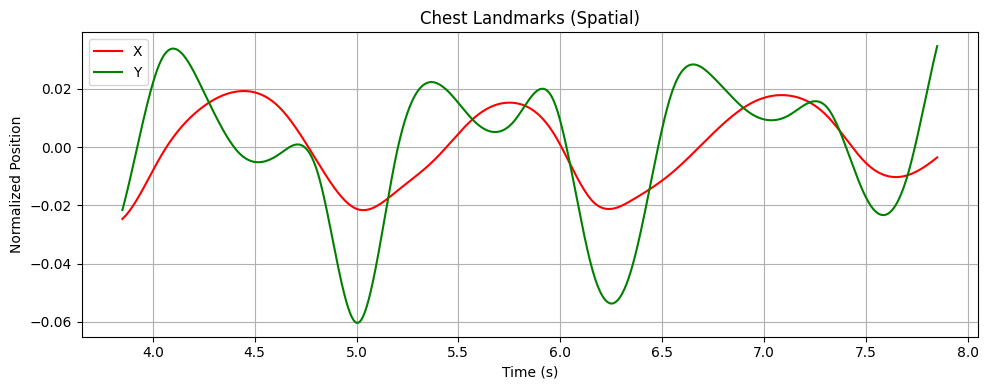

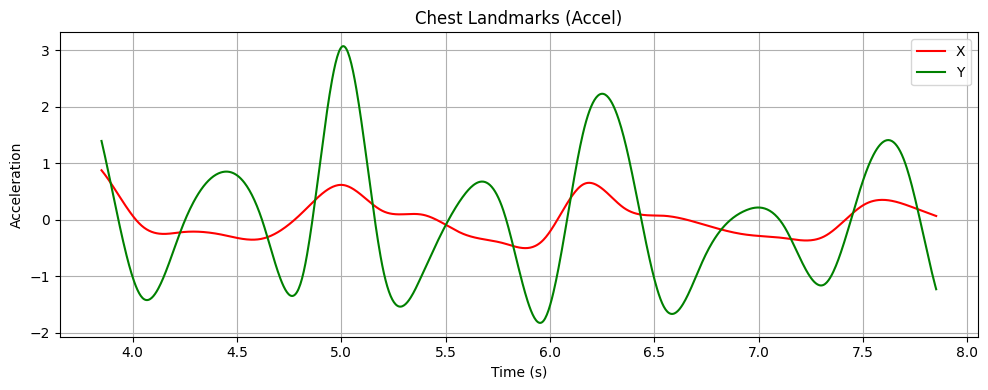

In [32]:
num_points = 1000
method = 'PS1'
d = 23
prime_coeff = next_prime(d)

scoring_pipeline_spatial = SW1PerS(start_time = np.min(segment), end_time = np.max(segment), num_points = num_points, method = method, d = d, prime_coeff = prime_coeff)
scoring_pipeline_accel = SW1PerS(start_time = np.min(segment), end_time = np.max(segment), num_points = num_points, method = method, d = d, prime_coeff = prime_coeff)

scoring_pipeline_spatial._detrend_and_convert(spline_funcs_spatial)
scoring_pipeline_accel._detrend_and_convert(spline_funcs_accel)

plt.figure(figsize=(10, 4))
plt.plot(scoring_pipeline_spatial.time_values, scoring_pipeline_spatial.X_detrended[:,0], color='r', label='X')
plt.plot(scoring_pipeline_spatial.time_values, scoring_pipeline_spatial.X_detrended[:,1], color='g', label='Y')
plt.title(f"{sensor} Landmarks (Spatial)")
plt.xlabel("Time (s)")
plt.ylabel("Normalized Position")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(scoring_pipeline_accel.time_values, scoring_pipeline_accel.X_detrended[:,0], color='r', label='X')
plt.plot(scoring_pipeline_accel.time_values, scoring_pipeline_accel.X_detrended[:,1], color='g', label='Y')
plt.title(f"{sensor} Landmarks (Accel)")
plt.xlabel("Time (s)")
plt.ylabel("Acceleration")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [33]:
scoring_pipeline_spatial._estimate_period()
period_pos = scoring_pipeline_spatial.period
print(f'Estimated Period Spatial Position: {period_pos}')
print('')
scoring_pipeline_accel._estimate_period()
period_accel = scoring_pipeline_accel.period
print(f'Estimated Period Acceleration: {period_accel}')
print('')

Estimated Period Spatial Position: 1.333333333333333

Estimated Period Acceleration: 0.6666666666666665



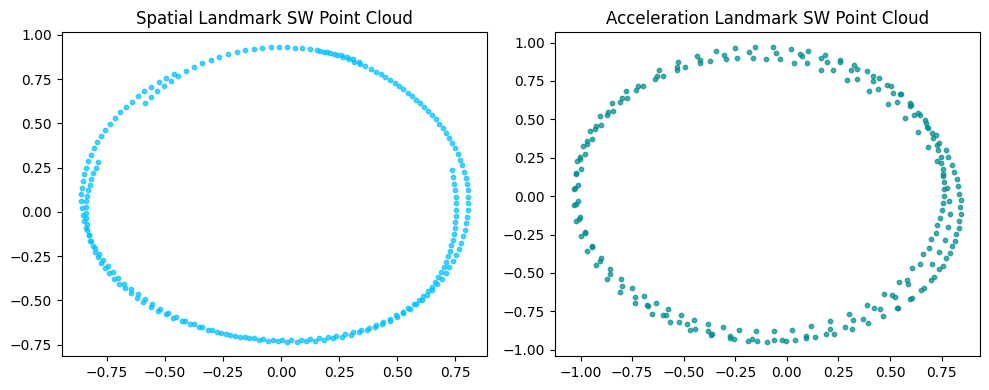

In [34]:
scoring_pipeline_spatial._sliding_windows()
scoring_pipeline_accel._sliding_windows()

from sklearn.decomposition import PCA

SW_spatial = scoring_pipeline_spatial.SW
SW_accel = scoring_pipeline_accel.SW

pca = PCA(n_components=2) 
proj_2D_spatial = pca.fit_transform(SW_spatial)
proj_2D_accel = pca.fit_transform(SW_accel)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))  

axes[0].scatter(proj_2D_spatial[:,0], proj_2D_spatial[:,1], s=10, alpha=0.7, color='deepskyblue')
axes[0].set_title(fr'Spatial Landmark SW Point Cloud')

axes[1].scatter(proj_2D_accel[:,0], proj_2D_accel[:,1], s=10, alpha=0.7, color='darkcyan')
axes[1].set_title(fr'Acceleration Landmark SW Point Cloud')

plt.tight_layout()
plt.show()

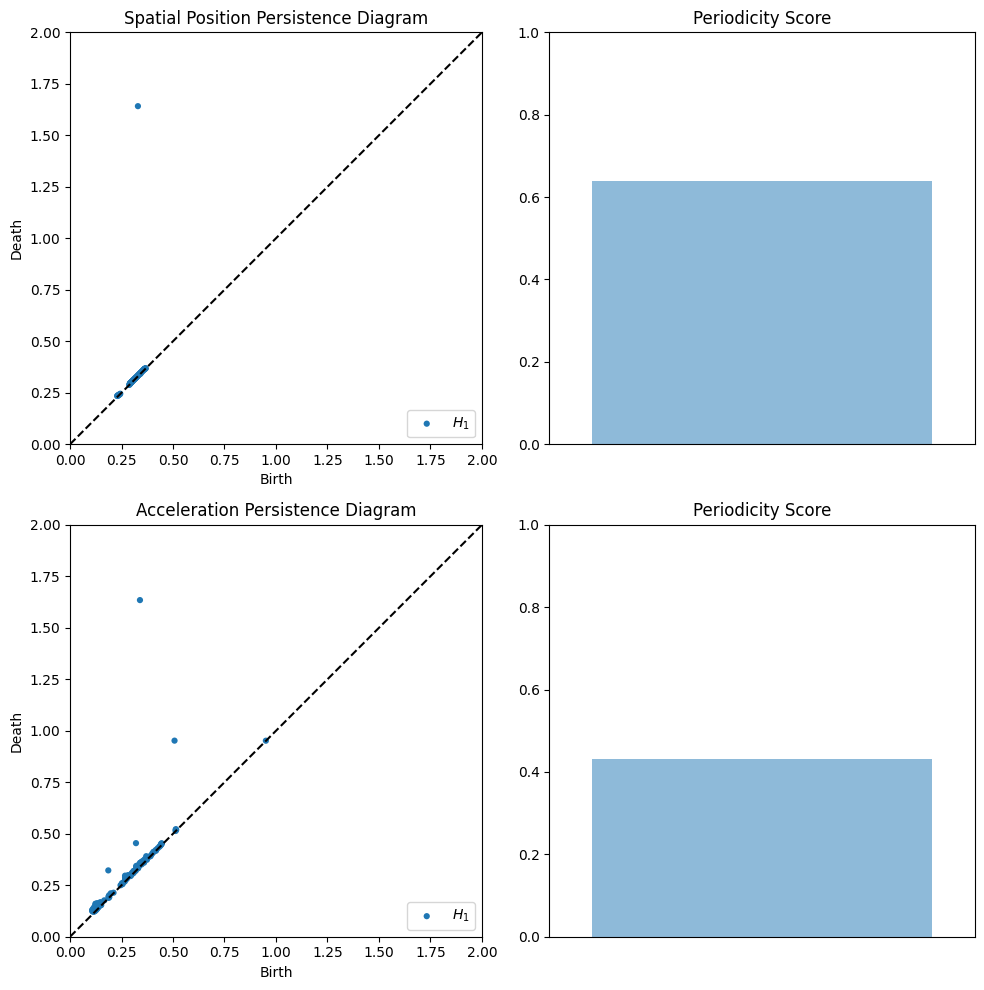

In [35]:
scoring_pipeline_spatial._1PerS()
scoring_pipeline_accel._1PerS()

if method == 'PS10':
    num = 10
    x_lim = 9.5
else:
    num = 1
    x_lim = 0.5

fig, axes = plt.subplots(2, 2, figsize=(10, 10)) 

plot_diagrams(scoring_pipeline_spatial.diagram, plot_only=[1], xy_range=[0, 2, 0, 2], ax = axes[0,0])
axes[0,0].set_title(fr'Spatial Position Persistence Diagram')

axes[0,1].bar(range(num), scoring_pipeline_spatial.periodicity_score, alpha=0.5)
axes[0,1].set_title(fr'Periodicity Score')
axes[0,1].set_xlim(-0.5, x_lim)
axes[0,1].set_ylim(0, 1)
axes[0,1].set_xticks([])

plot_diagrams(scoring_pipeline_accel.diagram, plot_only=[1], xy_range=[0, 2, 0, 2], ax = axes[1,0])
axes[1,0].set_title(fr'Acceleration Persistence Diagram')

axes[1,1].bar(range(num), scoring_pipeline_accel.periodicity_score, alpha=0.5)
axes[1,1].set_title(fr'Periodicity Score')
axes[1,1].set_xlim(-0.5, x_lim)
axes[1,1].set_ylim(0, 1)
axes[1,1].set_xticks([])

plt.tight_layout()
plt.show()